In [1]:
from IPython.core.display import display_html
from urllib.request import urlopen

display_html(urlopen('http://j.mp/1Ye5iWA').read(), raw=True)

# Dinámica del Robot Manipulador SCARA

Se tiene un robot manipulador tipo SCARA, como el de la siguiente figura, del cual se quiere obtener sus ecuaciones de movimiento, asi como una simulación bajo cierta ley de  control.



Empezaremos obteniendo una representación simple de las posiciones de los centros de masa para los eslabones del robot.

Primero tenemos que importar las librerias de computo simbolico:

In [2]:
from sympy import var, sin, cos, Matrix, Integer, eye, Function, Rational, exp, Symbol, I, solve, pi, trigsimp, dsolve, sinh, cosh, simplify
from sympy.physics.mechanics import mechanics_printing
mechanics_printing()

Y declaramos todas las constantes involucradas en este calculo simbolico:

In [3]:
var("m1 m2 m3 J1 J2 J3 l1 l2 L1 L2 L0 t g")

Asi como algunas de las variables de nuestro problema:

In [4]:
q1 = Function("q1")(t)
q2 = Function("q2")(t)
q3 = Function("q3")(t)

Y empezamos con el calculo de la posicion de los centros de masa de los eslabones, asi como su derivada y el cuadrado de la velocidad lineal de cada eslabon:

In [5]:
x1 = l1*cos(q1)
y1 = l1*sin(q1)
z1 = L0
v1 = x1.diff("t")**2 + y1.diff("t")**2 + z1.diff("t")**2
v1.trigsimp()

In [6]:
x2 = L1*cos(q1) + l2*cos(q1 + q2)
y2 = L1*sin(q1) + l2*sin(q1 + q2)
z2 = L0
v2 = x2.diff("t")**2 + y2.diff("t")**2 + z2.diff("t")**2
v2.trigsimp()

In [7]:
x3 = L1*cos(q1) + L2*cos(q1 + q2)
y3 = L1*sin(q1) + L2*sin(q1 + q2)
z3 = L0 - q3
v3 = x3.diff("t")**2 + y3.diff("t")**2 + z3.diff("t")**2
v3.trigsimp()

Declaramos $\omega_i$ como la velocidad angular de cada eslabon:

In [8]:
ω1 = q1.diff("t")
ω2 = q2.diff("t")
ω3 = 0

Y procedemos al calculo de la energía cinética de cada eslabon:

In [9]:
K1 = Rational(1, 2)*m1*v1 + Rational(1, 2)*J1*ω1**2
K1

In [10]:
K2 = Rational(1, 2)*m1*v2 + Rational(1, 2)*J2*ω2**2
K2

In [11]:
K3 = Rational(1, 2)*m1*v3 + Rational(1, 2)*J3*ω3**2
K3

Calculamos tambien la energía potencial de cada eslabon:

In [12]:
U1 = m1*g*z1
U1

In [13]:
U2 = m2*g*z2
U2

In [14]:
U3 = m3*g*z3
U3

Por lo que ya podemos calcular tanto la energía cinética de nuestro sistema como la potencial:

In [15]:
K = K1 + K2 + K3
K

In [16]:
U = U1 + U2 + U3
U

y el Lagrangiano queda:

In [17]:
L = (K - U).expand().simplify()
L

Por lo que ahora solo tenemos que aplicar la ecuación de Euler-Lagrange para obtener las ecuaciones de movimiento del sistema:

In [18]:
τ1 = (L.diff(q1.diff(t)).diff(t) - L.diff(q1)).simplify().expand().collect(q1.diff(t).diff(t)).collect(q2.diff(t).diff(t))

In [19]:
τ2 = (L.diff(q2.diff(t)).diff(t) - L.diff(q2)).simplify().expand().collect(q1.diff(t).diff(t)).collect(q2.diff(t).diff(t))

In [20]:
τ3 = (L.diff(q3.diff(t)).diff(t) - L.diff(q3)).simplify().expand().collect(q1.diff(t).diff(t)).collect(q2.diff(t).diff(t))

In [21]:
τ1

In [22]:
τ2

In [23]:
τ3

Una vez que tenemos las ecuaciones de movimiento, debemos simular el comportamiento del sistema por medio de la función ```odeint```, y obtener una gráfica de la trayectoria del sistema:

In [5]:
from scipy.integrate import odeint
from numpy import linspace

Para utilizar la función ```odeint```, debemos crear una función, que describa la dinámica del sistema:

In [6]:
def scara(estado, tiempo):
    # Se importan funciones necesarias
    from numpy import sin, cos, matrix
    # Se desenvuelven variables del estado y tiempo
    q1, q2, q3, q̇1, q̇2, q̇3 = estado
    t = tiempo
    
    # Se declaran constantes del sistema
    m1, m2, m3 = 1, 1, 1
    J1, J2, J3 = 1, 1, 1
    l1, l2 = 0.5, 0.5
    L1, L2 = 1, 1
    L = 1
    g = 9.81
    
    # Se declaran constantes del control
    kp1, kp2, kp3 = -30, -60, -60
    kv1, kv2, kv3 = -20, -20, -18
    
    # Señales de control nulas
    #tau1, tau2, tau3 = 0, 0, 0
    
    # Posiciones a alcanzar
    qd1, qd2, qd3 = 1, 1, 1
    
    # Se declaran señales de control del sistema
    tau1 = kp1*(q1 - qd1) + kv1*q̇1
    tau2 = kp2*(q2 - qd2) + kv2*q̇2
    tau3 = kp3*(q3 - qd3) + kv3*q̇3 + m3*g
    
    # Se calculan algunos terminos comunes
    λ1 = m1*L1*(l2 + L2)
    λ2 = m1*(l2**2 + L2**2)
    λ3 = m1*(l1**2 + L1**2)
    
    # Se calculan las matrices de masas, Coriolis,
    # y vectores de gravedad, control, posicion y velocidad
    M = matrix([[J1 + 2*λ1*cos(q2) + m1*L1**2 + λ2 + λ3, λ1*cos(q2) + λ2, 0],
                [λ1*cos(q2) + λ2, J2 + λ2, 0],
                [0, 0, m1]])
    C = matrix([[-2*q̇1, -q̇2, 0], [q̇1, 0, 0], [0, 0, 0]])
    G = matrix([[0], [0], [-m3*g]])
    Tau = matrix([[tau1], [tau2], [tau3]])
    q = matrix([[q1], [q2], [q3]])
    q̇ = matrix([[q̇1], [q̇2], [q̇3]])
    
    # Se calcula la derivada del estado del sistema
    qp1 = q̇1
    qp2 = q̇2
    qp3 = q̇3
    
    qpp = M.I*(Tau - C*q̇ - G)
    qpp1, qpp2, qpp3 = qpp.tolist()
    
    return [qp1, qp2, qp3, qpp1[0], qpp2[0], qpp3[0]]

Y declarar un arreglo con todos los tiempos a simular, mandar a llamar a la función ```odeint```, y listo!

In [7]:
t = linspace(0, 10, 1000)
estados_simulados = odeint(func = scara, y0  = [0, 0, 0, 0, 0, 0], t = t)

Desempacamos los elementos que nos entrega ```odeint```:

In [8]:
q1, q2, q3, q̇1, q̇2, q̇3 = list(zip(*estados_simulados.tolist()))

Importamos la libreria para graficar:

In [9]:
%matplotlib notebook
from matplotlib.pyplot import plot, style, figure
from mpl_toolkits.mplot3d import Axes3D
style.use("ggplot")

Hacemos la grafica de las trayectorias del sistema, $q_1$, $q_2$ y $q_3$:

<IPython.core.display.Javascript object>


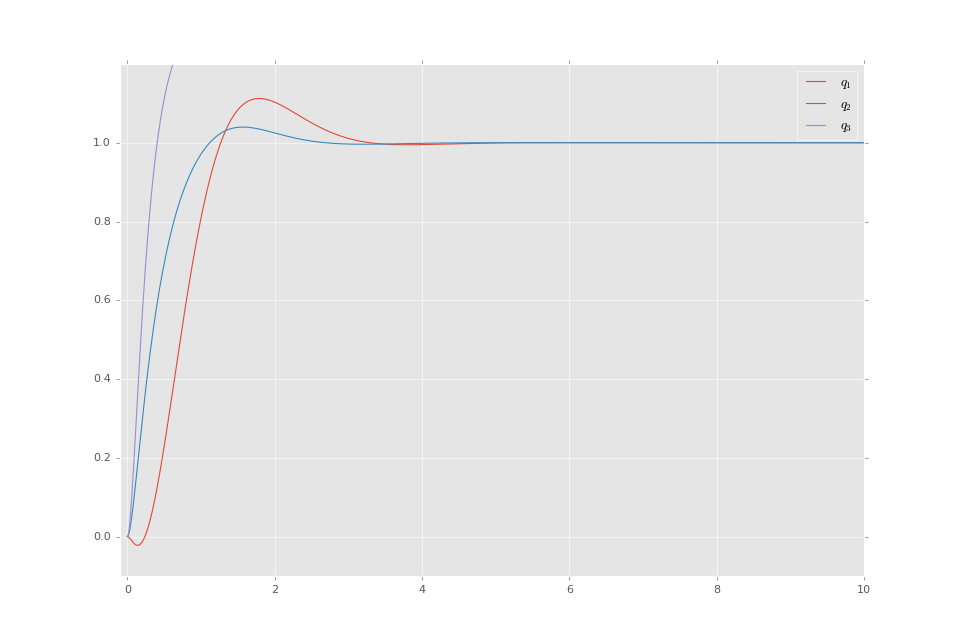

In [10]:
fig1 = figure(figsize=(12, 8))

ax1 = fig1.gca()

p1, = ax1.plot(t, q1)
p2, = ax1.plot(t, q2)
p3, = ax1.plot(t, q3)
ax1.legend([p1, p2, p3],[r"$q_1$", r"$q_2$", r"$q_3$"])
ax1.set_ylim(-0.1, 1.2)
ax1.set_xlim(-0.1, 10);

Realizamos la cinemática del manipulador para poder graficar en 3D:

In [11]:
def tras_x(x):
    from numpy import matrix
    A = matrix([[1, 0, 0, x],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
    return A

def tras_z(z):
    from numpy import matrix
    A = matrix([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, z],
                [0, 0, 0, 1]])
    return A

def rot_z(θ):
    from numpy import matrix, sin, cos
    A = matrix([[cos(θ), -sin(θ), 0, 0],
                [sin(θ), cos(θ), 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
    return A

def cinematica_scara(q1, q2, q3, l1, l2, L):
    from numpy import matrix
    p0 = matrix([[0], [0], [0], [1]])
    p1 = tras_z(L)*p0
    p2 = rot_z(q1)*tras_x(l1)*p1
    p3 = rot_z(q2)*tras_x(l2)*p2
    p4 = tras_z(-q3)*p3
    
    return [[p0.tolist()[0][0], p1.tolist()[0][0], p2.tolist()[0][0], p3.tolist()[0][0], p4.tolist()[0][0]],
             [p0.tolist()[1][0], p1.tolist()[1][0], p2.tolist()[1][0], p3.tolist()[1][0], p4.tolist()[1][0]],
             [p0.tolist()[2][0], p1.tolist()[2][0], p2.tolist()[2][0], p3.tolist()[2][0], p4.tolist()[2][0]]]

In [12]:
from numpy import pi
τ = 2*pi
xs, ys, zs = cinematica_scara(τ/12, τ/9, 0.5, 1, 1, 1)

<IPython.core.display.Javascript object>


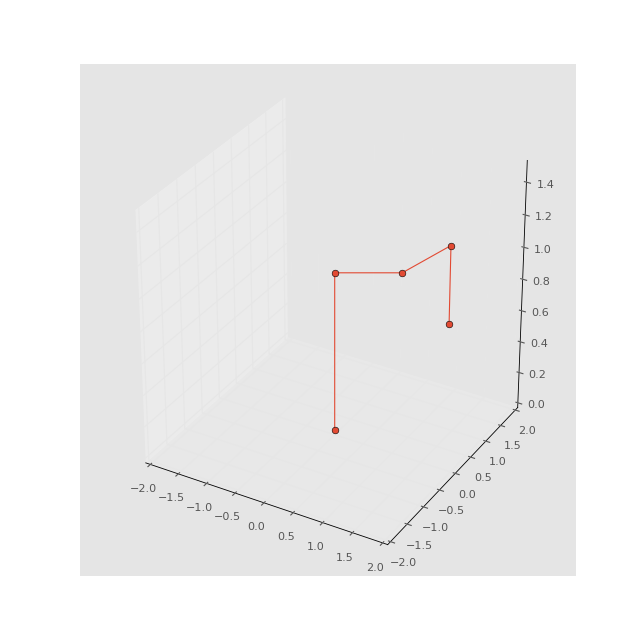

In [13]:
fig2 = figure(figsize=(8, 8))
ax2 = fig2.gca(projection='3d')
ax2.plot(xs, ys, zs, "-o")
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_zlim(0, 1.5);

Cambiamos el ambiente de matplotlib, para poder graficar interactivamente, y declaramos una función que tome la cinematica del robot y grafique los puntos:

In [14]:
%matplotlib inline

In [15]:
def grafica_scara(q1, q2, q3, l1, l2, L):
    xs, ys , zs = cinematica_scara(q1, q2, q3, l1, l2, L)
    
    fig = figure(figsize=(8, 8))
    
    ax = fig.gca(projection='3d')
    
    ax.plot(xs, ys, zs, "-o")
    
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 1.5);

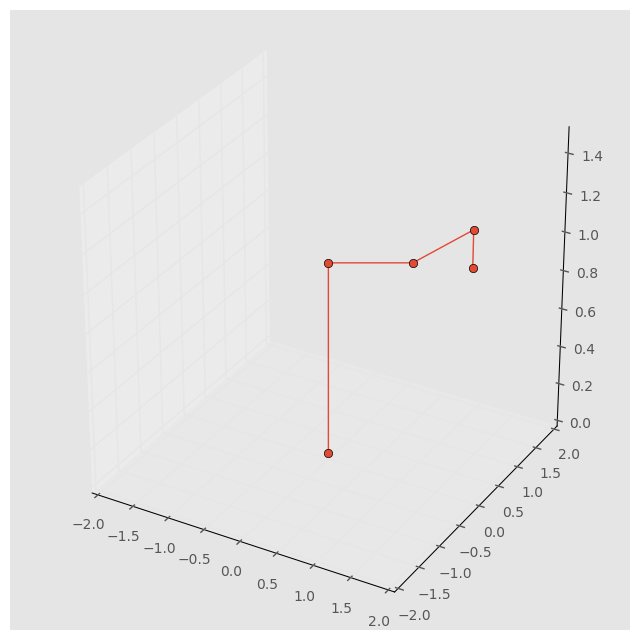

In [16]:
grafica_scara(τ/12, τ/9, 0.2, 1, 1, 1)

Importamos la libreria para interactuar con los datos y le pasamos la función que grafica:

In [17]:
# Se importan widgets de IPython para interactuar con la funcion
from IPython.html.widgets import interact, fixed

/Users/roberto/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


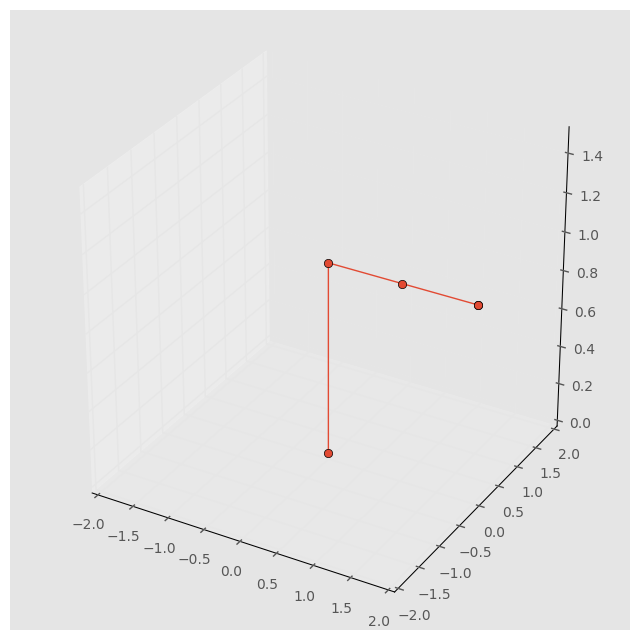

In [18]:
# Se llama a la funcion interactiva
interact(grafica_scara, q1=(0, τ), q2=(0, τ), q3=(0, 1.0), l1=fixed(1), l2=fixed(1), L=fixed(1))

Para realizar una animación con los datos de la simulación primero importamos la libreria necesaria y creamos la misma grafica dentro del ambiente de animación:

In [39]:
from matplotlib import animation
from numpy import arange

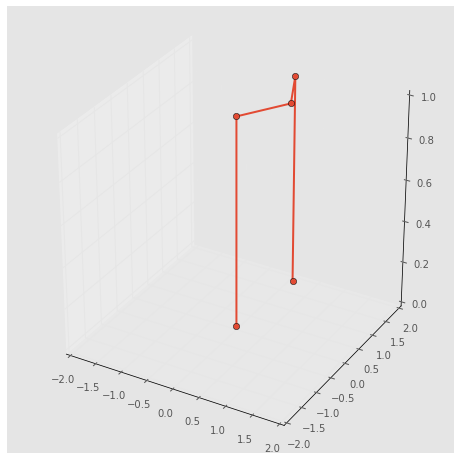

In [40]:
# Se define el tamaño de la figura
fig = figure(figsize=(8, 8))

# Se define una sola grafica en la figura y se dan los limites de los ejes x y y
axi = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2), projection='3d')

# Se utilizan graficas de linea para el resorte y amortiguador
robot, = axi.plot([], [], [], "-o", lw=2)

def init():
    # Esta funcion se ejecuta una sola vez y sirve para inicializar el sistema
    robot.set_data([], [])
    return robot

def animate(i):
    # Esta funcion se ejecuta para cada cuadro del GIF
    
    # Se obtienen las coordenadas del robot y se meten los datos en su grafica de linea
    xs, ys, zs = cinematica_scara(q1[i], q2[i], q3[i], 1, 1, 1)
    robot.set_data(xs, ys)
    robot .set_3d_properties(zs)
    
    return robot

# Se hace la animacion dandole el nombre de la figura definida al principio, la funcion que
# se debe ejecutar para cada cuadro, el numero de cuadros que se debe de hacer, el periodo 
# de cada cuadro y la funcion inicial
ani = animation.FuncAnimation(fig, animate, arange(1, len(q1)), interval=25,
                              blit=True, init_func=init)

# Se guarda el GIF en el archivo indicado
ani.save('./imagenes/simulacion-scara.gif', writer='imagemagick');

![](./imagenes/simulacion-scara.gif)